In [ ]:
final_propagator = propagate_from_pulses(H0, H_controls, result["u_list"], 1)
println("Final propagator matrix:")
println(final_propagator)

LoadError: UndefVarError: `propagate_from_pulses` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [31]:
import Pkg; Pkg.add("DifferentialEquations")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed BoundaryValueDiffEqFIRK ───────────── v1.9.0
   Installed OrdinaryDiffEqRosenbrock ──────────── v1.18.1
   Installed OrdinaryDiffEqStabilizedRK ────────── v1.4.0
   Installed OrdinaryDiffEqSDIRK ───────────────── v1.7.0
   Installed DifferentialEquations ─────────────── v7.17.0
   Installed Polyester ─────────────────────────── v0.7.18
   Installed AlmostBlockDiagonals ──────────────── v0.1.10
   Installed BoundaryValueDiffEqMIRK ───────────── v1.9.0
   Installed Sundials_jll ──────────────────────── v7.5.0+0
   Installed OrdinaryDiffEqRKN ─────────────────── v1.5.0
   Installed NonlinearSolve ────────────────────── v4.12.0
   Installed Static ────────────────────────────── v1.3.1
   Installed Distances ─────────────────────────── v0.10.12
   Installed OrdinaryDiffEqSSPRK ───────────────── v1.7.0
   Installed OrdinaryDiffEqCore ────────────────── v1.36.0
   Installed BoundaryValueD

 RK4 approximates the time integral with high-order interpolation

## Comparison between discrete pulse and continous pulse (found by discrete coefficients)


╔════════════════════════════════════════════════════════════════════╗
║  QUANTUM CONTROL: Piecewise vs Continuous Fourier                ║
║  Propagator Fidelity vs Paired-State Fidelity                    ║
║  Solve Schrödinger TWICE from ψ_Zgpos and ψ_Zgminus             ║
╚════════════════════════════════════════════════════════════════════╝

Iter     Function value   Gradient norm 
     0     8.058667e-01     2.754971e-01
 * time: 8.988380432128906e-5
     1     6.812406e-01     1.017370e-01
 * time: 61.66211295127869
     2     6.598001e-01     1.166269e-01
 * time: 122.5600209236145
     3     6.096124e-01     2.054857e-01
 * time: 216.59706282615662
     4     5.684399e-01     2.544390e-01
 * time: 309.8392469882965
     5     4.851621e-01     1.556606e-01
 * time: 414.1320879459381
     6     4.405813e-01     9.878772e-02
 * time: 477.55944180488586
     7     4.224382e-01     9.108092e-02
 * time: 538.0885348320007
     8     4.069922e-01     1.004309e-01
 * time: 629.087918

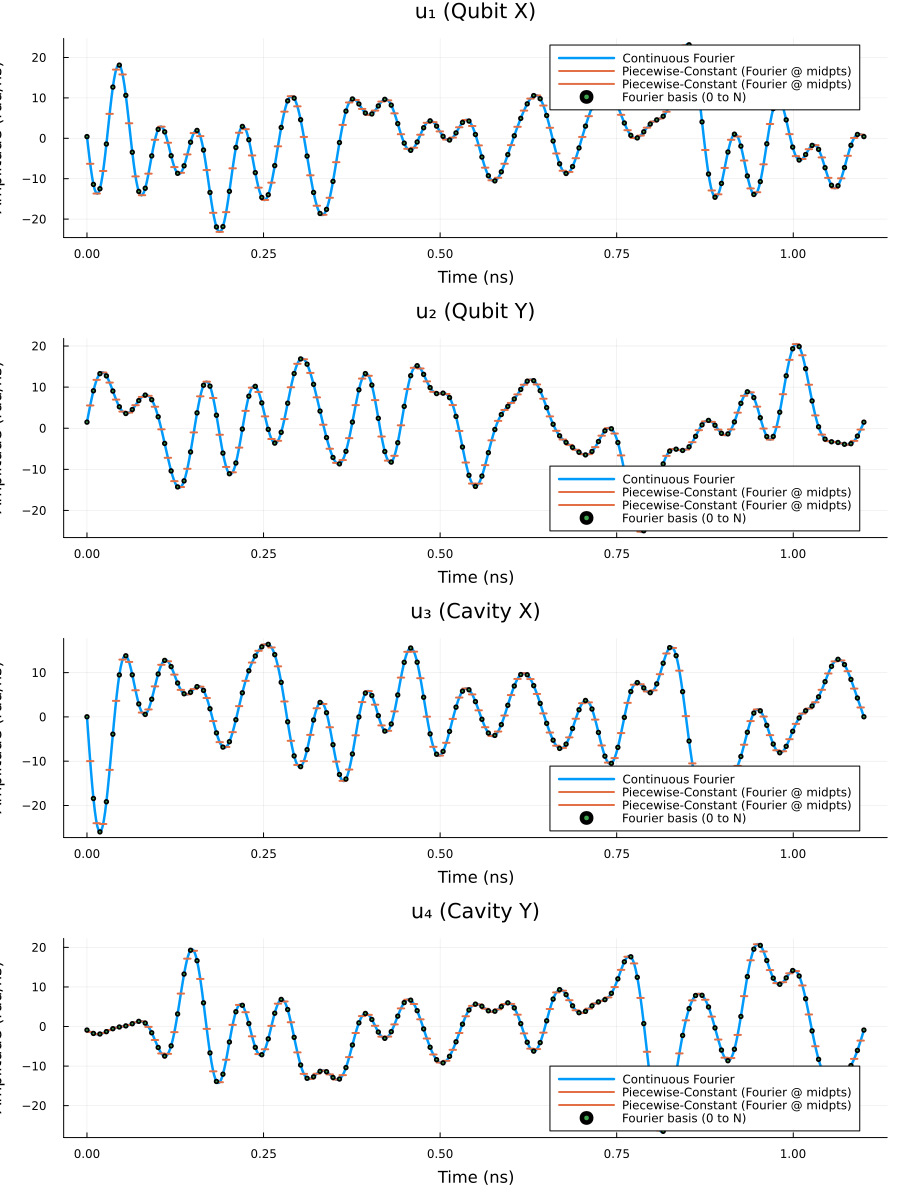

✓ Plot saved: pulses_comparison.png



(Dict{String, Any}("theta" => [0.41475632112954136, -0.08580940765919029, -3.141592653589793, -2.6381057420400045, -0.5633609655871181, -3.0413295909736062, 3.141592653589793, 0.7485030778963658, 0.30547116220305937, 0.4677705304681727  …  1.2725547367222452, -0.09235019530276685, 1.6753318980268501, 2.372191448673368, 1.73547462723535, -0.48655423265445835, -0.7275239660563818, -0.6458726541250046, -2.3060773314696728, 0.47557776982388145], "H_controls" => Matrix{ComplexF64}[[0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im], [0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im], [0.0 + 0.0im 1.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0

In [48]:
using LinearAlgebra, Random, Optim, Plots, DifferentialEquations

# ============================================================================
# SYSTEM DEFINITIONS
# ============================================================================
function zL_minus_cavity(alpha::Real; d_c::Int)
    ψ = zeros(BigFloat, d_c)
    for n in 0:fld(d_c-3, 4)
        k = 4n + 2
        ψ[k+1] = BigFloat(alpha)^k / sqrt(BigFloat(factorial(big(k))))
    end
    ψ ./= sqrt(sum(abs2, ψ))
    return ComplexF64.(ψ)
end

function zL_cavitypos(alpha::Real; d_c::Int)
    ψ = zeros(BigFloat, d_c)
    for n in 0:fld(d_c-1, 4)
        k = 4n
        ψ[k+1] = BigFloat(alpha)^k / sqrt(BigFloat(factorial(big(k))))
    end
    ψ ./= sqrt(sum(abs2, ψ))
    return ComplexF64.(ψ)
end

α = sqrt(3)
ψ_cavidealminus = zL_minus_cavity(α; d_c=15)
ψ_cavidealpos = zL_cavitypos(α; d_c=15)
ground_state = zeros(ComplexF64, 15)
excited_state = zeros(ComplexF64, 15)
ground_state[1] = 1.0 + 0im
excited_state[2] = 1.0 + 0im
ψ_Zgminus = kron(ground_state[1:4], ψ_cavidealminus)
ψ_Zgpos = kron(ground_state[1:4], ψ_cavidealpos)

function make_system(; d_q=4, d_c=15)
    Iq = Matrix{ComplexF64}(I, d_q, d_q)
    a = zeros(ComplexF64, d_c, d_c)
    for n in 2:d_c; a[n-1, n] = sqrt(n-1) end
    b = zeros(ComplexF64, d_q, d_q)
    for n in 2:d_q; b[n-1, n] = sqrt(n-1) end
    a⁺, b⁺ = a', b'
    Ic = Matrix{ComplexF64}(I, d_c, d_c)

    H_osc = (-0.0037*2π/2) * kron(Iq, a⁺*a⁺*a*a)
    H_trans = (-236.0*2π/2) * kron(b⁺*b⁺*b*b, Ic)
    H_int = (-2.194*2π) * kron(b⁺*b, a⁺*a) + (-0.019*2π/2) * kron(b⁺*b, a⁺*a⁺*a*a)
    H0 = H_osc + H_trans + H_int
    
    return H0, [kron(b+b⁺, Ic), kron(1im*(b⁺-b), Ic), kron(Iq, a+a⁺), kron(Iq, 1im*(a⁺-a))]
end

# ============================================================================
# FIDELITY FUNCTIONS
# ============================================================================
function fidelity_from_propagator(U)
    """Fidelity from propagator: real(abs((ψ_Zgpos)'*U*ψ_Zgminus)^2 + abs((ψ_Zgminus)'*U*ψ_Zgpos)^2) / 2"""
    return real(abs((ψ_Zgpos)'*U*ψ_Zgminus)^2 + abs((ψ_Zgminus)'*U*ψ_Zgpos)^2) / 2
end

function fidelity_from_two_states(ψ_final1, ψ_final2)
    """
    Fidelity from TWO final states (paired - SWAP gate):
    ψ_final1 evolved from ψ_Zgminus
    ψ_final2 evolved from ψ_Zgpos
    Fidelity = real(abs((ψ_Zgpos)'*ψ_final1)^2 + abs((ψ_Zgminus)'*ψ_final2)^2) / 2
    
    Measures: ψ_Zgminus → ψ_final1 ≈ ψ_Zgpos? AND ψ_Zgpos → ψ_final2 ≈ ψ_Zgminus?
    """
    return real(abs((ψ_Zgpos)'*ψ_final1)^2 + abs((ψ_Zgminus)'*ψ_final2)^2) / 2
end

# ============================================================================
# FOURIER BASIS AT 0 TO N
# ============================================================================
function fourier_sine_bank(N, K)
    t = collect(0:N)
    M = zeros(Float64, K, N+1)
    for r in 1:K
        M[r, :] = sin.(π * r * t / N)
    end
    return M
end

function coeffs_to_pulses(theta, N, K; m=4)
    S = fourier_sine_bank(N, K)
    u_list = []
    ofs = 1
    for _j in 1:m
        b0 = theta[ofs]
        br = theta[ofs+1:ofs+K]
        u = b0 .+ (br' * S)[:]
        push!(u_list, u)
        ofs += (K+1)
    end
    return u_list
end

# ============================================================================
# PIECEWISE-CONSTANT: Fourier at midpoints
# ============================================================================
function pulses_at_midpoints(theta, N, K; m=4)
    u_const = []
    ofs = 1
    for j in 1:m
        b0 = theta[ofs]
        br = theta[ofs+1:ofs+K]
        u_j_const = Float64[]
        for k in 1:N
            t_mid = k - 0.5
            u_val = b0 + sum(br[r] * sin(π * r * t_mid / N) for r in 1:K)
            push!(u_j_const, u_val)
        end
        push!(u_const, u_j_const)
        ofs += (K+1)
    end
    return u_const
end

function propagate_piecewise(H0, H_controls, theta, T, N, K)
    """Piecewise propagator: returns U(T) for fidelity_from_propagator"""
    dt = T / N
    u_const = pulses_at_midpoints(theta, N, K, m=length(H_controls))
    
    d = size(H0, 1)
    U = Matrix{ComplexF64}(I, d, d)
    
    for k in 1:N
        H = copy(H0)
        for j in 1:length(H_controls)
            H += u_const[j][k] * H_controls[j]
        end
        U = exp(-1im * H * dt) * U
    end
    return U
end

# ============================================================================
# COMPUTE PROPAGATOR FROM ODE SOLUTION
# ============================================================================
function compute_propagator_from_ode(H0, H_controls, theta, T, K, abstol=1e-10, reltol=1e-10, maxiters=100000)
    """
    Compute propagator U(T) by evolving all basis vectors via ODE
    This allows fair comparison: both methods compute propagator
    """
    d = size(H0, 1)
    U = zeros(ComplexF64, d, d)
    
    # Evolve each basis vector
    for i in 1:d
        e_i = zeros(ComplexF64, d)
        e_i[i] = 1.0
        
        # Solve Schrödinger from e_i
        ψ_final = solve_schrodinger_continuous(H0, H_controls, theta, T, K, e_i, 
                                            abstol=abstol, reltol=reltol, maxiters=maxiters)
        U[:, i] = ψ_final
    end
    
    return U
end
function solve_schrodinger_continuous(H0, H_controls, theta, T, K, ψ_init; abstol=1e-10, reltol=1e-10, maxiters=100000)
    """
    Solve: i*dψ/dt = H(t)*ψ with continuous Fourier series
    For large Hamiltonian values, use larger maxiters and less strict tolerances
    Returns: ψ(T) for fidelity_from_state
    """
    d = size(H0, 1)
    
    # Extract Fourier coefficients
    b_coeffs = []
    ofs = 1
    m = length(H_controls)
    for j in 1:m
        b0 = theta[ofs]
        br = theta[ofs+1:ofs+K]
        push!(b_coeffs, vcat(b0, br))
        ofs += (K+1)
    end
    
    # ODE: dψ/dt = -i H(t) ψ
    function schrodinger!(dψ, ψ, p, t)
        H = copy(H0)
        for j in 1:m
            b_vals = b_coeffs[j]
            u_val = b_vals[1] + sum(b_vals[r+1] * sin(π * r * t / T) for r in 1:K)
            H += u_val * H_controls[j]
        end
        dψ .= -1im * H * ψ
    end
    
    prob = ODEProblem(schrodinger!, ψ_init, (0.0, T))
    sol = solve(prob, Tsit5(), abstol=abstol, reltol=reltol, dense=false, maxiters=maxiters)
    
    # Extract timesteps used by the solver
    n_steps = length(sol.t)
    println("    ODE Solver Info:")
    println("    - Number of steps taken: $n_steps")
    if n_steps > 1
        dt_min = minimum(diff(sol.t))
        dt_max = maximum(diff(sol.t))
        dt_avg = T / n_steps
        println("    - Min timestep: $dt_min")
        println("    - Max timestep: $dt_max")
        println("    - Avg timestep: $dt_avg")
    end
    
    return sol.u[end]
end

# ============================================================================
# COST FUNCTION AND OPTIMIZATION
# ============================================================================
function cost_function(theta, H0, H_controls, T, N, K; max_amp=5*pi*2, penalty_weight=1000.0)
    u_const = pulses_at_midpoints(theta, N, K, m=length(H_controls))
    penalty = sum(sum(max.(abs.(u_j) .- max_amp, 0.0).^2) for u_j in u_const)
    
    U = propagate_piecewise(H0, H_controls, theta, T, N, K)
    F = fidelity_from_propagator(U)
    
    return 1.0 - F + penalty_weight * penalty
end

function run_optimization(T, N, K; seed=42, init_scale=1.0*π, maxiter=100)
    H0, H_controls = make_system()
    m = length(H_controls)
    
    Random.seed!(seed)
    theta0 = Float64[]
    for _ in 1:m
        push!(theta0, 0.0)
        append!(theta0, init_scale * (2*rand(K) .- 1))
    end

    res = optimize(th -> cost_function(clamp.(th, -init_scale, init_scale), H0, H_controls, T, N, K),
                theta0, Optim.LBFGS(), Optim.Options(iterations=maxiter, f_abstol=1e-8, x_abstol=1e-8, show_trace=true))
    
    theta = clamp.(Optim.minimizer(res), -init_scale, init_scale)
    u_list = coeffs_to_pulses(theta, N, K, m=m)
    U_pw = propagate_piecewise(H0, H_controls, theta, T, N, K)
    F_pw = fidelity_from_propagator(U_pw)

    println("\n✓ Optimization Complete! Piecewise Fidelity (from U): $F_pw")

    return Dict("theta" => theta, "u_list" => u_list, "F_pw" => F_pw, "H0" => H0, "H_controls" => H_controls)
end

# ============================================================================
# COMPARISON: Piecewise (propagator) vs Continuous Fourier (state)
# ============================================================================
function compare_methods(opt_result, T, K; solver_abstol=1e-8, solver_reltol=1e-8, solver_maxiters=100000)
    H0, H_controls = opt_result["H0"], opt_result["H_controls"]
    theta = opt_result["theta"]
    
    F_pw = opt_result["F_pw"]
    
    println("\n✓ Solving continuous Fourier Schrödinger equation (TWO times)...")
    println("  ODE Solver: Tsit5 (adaptive)")
    println("  Tolerances: abstol=$solver_abstol, reltol=$solver_reltol")
    println("  Max iterations: $solver_maxiters")
    
    # Solve from ψ_Zgminus → ψ_final1
    println("  1. From ψ_Zgminus → ψ_final1")
    ψ_final1 = solve_schrodinger_continuous(H0, H_controls, theta, T, K, ψ_Zgminus, 
                                        abstol=solver_abstol, reltol=solver_reltol, maxiters=solver_maxiters)
    
    # Solve from ψ_Zgpos → ψ_final2
    println("  2. From ψ_Zgpos → ψ_final2")
    ψ_final2 = solve_schrodinger_continuous(H0, H_controls, theta, T, K, ψ_Zgpos, 
                                        abstol=solver_abstol, reltol=solver_reltol, maxiters=solver_maxiters)
    
    F_ode = fidelity_from_two_states(ψ_final1, ψ_final2)
    
    println("\n" * "="^70)
    println("FIDELITY COMPARISON (SWAP gate)")
    println("="^70)
    println("A. Piecewise (N=120 fixed steps):              F_pw = $F_pw")
    println("   ψ_Zgminus ──U──→ U·ψ_Zgminus, measure overlap with ψ_Zgpos")
    println("   ψ_Zgpos ──U──→ U·ψ_Zgpos, measure overlap with ψ_Zgminus")
    println("   Formula: real(abs((ψ_Zgpos)'*U*ψ_Zgminus)^2 + abs((ψ_Zgminus)'*U*ψ_Zgpos)^2) / 2")
    println()
    println("B. Continuous Fourier (ODE Schrödinger):      F_ode = $F_ode")
    println("   ψ_Zgminus ──Schrödinger──→ ψ_final1, measure overlap with ψ_Zgpos")
    println("   ψ_Zgpos ──Schrödinger──→ ψ_final2, measure overlap with ψ_Zgminus")
    println("   Formula: real(abs((ψ_Zgpos)'*ψ_final1)^2 + abs((ψ_Zgminus)'*ψ_final2)^2) / 2")
    println()
    println("Fidelity Difference: $(abs(F_pw - F_ode))")
    println("Relative Difference: $(abs(F_pw - F_ode) / abs(F_ode) * 100)%")
    println("="^70)
    
    return Dict("F_pw" => F_pw, "F_ode" => F_ode, "diff" => abs(F_pw - F_ode))
end

# ============================================================================
# VISUALIZATION
# ============================================================================
function plot_comparison(u_list, theta, T, N, K)
    dt = T / N
    t_fourier = collect(0:N) * dt
    t_steps = [collect(0:N-1) * dt; T]
    t_fine = range(0.0, T, length=5*N)
    
    u_const = pulses_at_midpoints(theta, N, K, m=4)
    
    b_coeffs = []
    ofs = 1
    for j in 1:4
        b0 = theta[ofs]
        br = theta[ofs+1:ofs+K]
        push!(b_coeffs, vcat(b0, br))
        ofs += (K+1)
    end
    
    u_continuous = []
    for j in 1:4
        b_vals = b_coeffs[j]
        u_j = b_vals[1] .+ sum(b_vals[r+1] * sin.(π * r * t_fine ./ T) for r in 1:K)
        push!(u_continuous, u_j)
    end
    
    gr()
    plots_array = []
    labels = ["u₁ (Qubit X)", "u₂ (Qubit Y)", "u₃ (Cavity X)", "u₄ (Cavity Y)"]
    
    for idx in 1:4
        p = plot(size=(800, 300), title=labels[idx], legend=true)
        
        plot!(p, t_fine, u_continuous[idx], linewidth=2.5, label="Continuous Fourier", color=1)
        
        for k in 1:N
            plot!(p, [t_steps[k], t_steps[k+1]], [u_const[idx][k], u_const[idx][k]], 
                linewidth=2, label=(k==1 ? "Piecewise-Constant (Fourier @ midpts)" : ""), 
                color=2, legend=false)
        end
        plot!(p, [], [], linewidth=2, label="Piecewise-Constant (Fourier @ midpts)", color=2)
        
        plot!(p, t_fourier, u_list[idx], linewidth=1, label="Fourier basis (0 to N)", 
            linetype=:scatter, color=3, markersize=2)
        
        xlabel!(p, "Time (ns)")
        ylabel!(p, "Amplitude (rad/ns)")
        plot!(p, grid=true, legend=:best)
        push!(plots_array, p)
    end
    
    p_combined = plot(plots_array..., layout=(4, 1), size=(900, 1200))
    display(p_combined)
    savefig(p_combined, "pulses_comparison.png")
end

# ============================================================================
# MAIN
# ============================================================================
function main()
    T, N, K = 1.1, 120, 40
    
    println("\n╔════════════════════════════════════════════════════════════════════╗")
    println("║  QUANTUM CONTROL: Piecewise vs Continuous Fourier                ║")
    println("║  Propagator Fidelity vs Paired-State Fidelity                    ║")
    println("║  Solve Schrödinger TWICE from ψ_Zgpos and ψ_Zgminus             ║")
    println("╚════════════════════════════════════════════════════════════════════╝\n")
    
    opt_result = run_optimization(T, N, K, seed=42, init_scale=1.0*π, maxiter=200)
    
    # For large Hamiltonian values, use looser tolerances and more iterations
    comparison = compare_methods(opt_result, T, K, 
                                solver_abstol=1e-8, 
                                solver_reltol=1e-8, 
                                solver_maxiters=100000)
    
    println("\nVISUALIZATION")
    plot_comparison(opt_result["u_list"], opt_result["theta"], T, N, K)
    println("✓ Plot saved: pulses_comparison.png\n")
    
    return opt_result, comparison
end

opt_result, comparison = main()